# calc_clusters

This is the fifth step in reproducing the cluster analysis following [Amini and Straus 2019]
https://doi.org/10.1007/s00382-018-4409-7

This program calculates and plots the composite cluster maps.

* Input: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.pcs.nc` and `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc`

* Output: `figs/ERAI_clusters_5_1980-2015_DJF.png`, `figs/ERAI_clusters_4_1980-2015_DJF.png`, `figs/ERAI_clusters_6_1980-2015_DJF.png`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker


from sklearn.cluster import KMeans

### Filename and path

In [2]:
path='/project/predictability/kpegion/wxregimes/era-interim/'
fname='erai.z500_u250_pna_5dyrm_DJF.1980-2015.pcs.nc'

### Read PCs

In [3]:
ds=xr.open_dataset(path+fname)
ds

<xarray.Dataset>
Dimensions:  (pcnum: 12, time: 3080)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 3073 3074 3075 3076 3077 3078 3079
  * pcnum    (pcnum) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    pcs      (time, pcnum) float64 ...

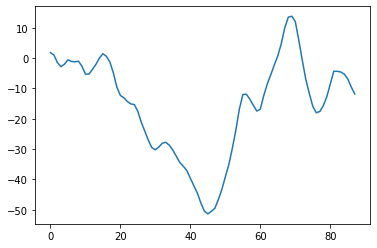

In [4]:
plt.plot(ds['pcs'][0:88,0])

### Read anomalies

In [5]:
fname_anoms='erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc'

In [6]:
ds_anoms=xr.open_dataset(path+fname_anoms)
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 3080)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 3073 3074 3075 3076 3077 3078 3079
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...

### KMeans 5

In [7]:
# Apply KMeans to get the clusters centriods
kmeans5 = KMeans(n_clusters=5,random_state=1,init='random',n_init=100)
kmeans5.fit(ds['pcs'])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=100, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

In [8]:
# Identify the cluster for each day
y_kmeans5=kmeans5.predict(ds['pcs'])

In [9]:
# Re-assign the time dimension to contain the cluster assigned to each day
ds_anoms['time']=y_kmeans5
ds_anoms=ds_anoms.rename({'time':'cluster'})
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3080, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 2 2 2 2
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

### Group the data by the cluster and take the mean over each cluster to get the composites

In [10]:
cluster_comp=ds_anoms.groupby('cluster').mean()
cluster_comp

<xarray.Dataset>
Dimensions:  (cluster: 5, lat: 22, lon: 53)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * cluster  (cluster) int64 0 1 2 3 4
Data variables:
    z500     (cluster, lat, lon) float64 704.2 729.6 753.6 ... -43.12 -26.55
    u250     (cluster, lat, lon) float64 6.086 6.494 6.876 ... 5.26 5.083 4.843

### Calculate the Cluster Frequency

In [11]:
cluster_freq=(ds_anoms.groupby('cluster').count())/len(ds['time'])
cluster_freq['z500'][:,0,0]

<xarray.DataArray 'z500' (cluster: 5)>
array([0.13766234, 0.25      , 0.14318182, 0.21655844, 0.2525974 ])
Coordinates:
  * cluster  (cluster) int64 0 1 2 3 4
    lat      float64 79.53
    lon      float64 151.9

### Set Map Information

In [12]:
cm = 225
proj = ccrs.EquidistantConic(central_longitude=cm)
minlon = -30 + cm
maxlon = +120 + cm
lat_labels=np.arange(20,90,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,20,90]

### Plot the composite cluster maps, reproducing Amini and Straus 2019 Figure 2

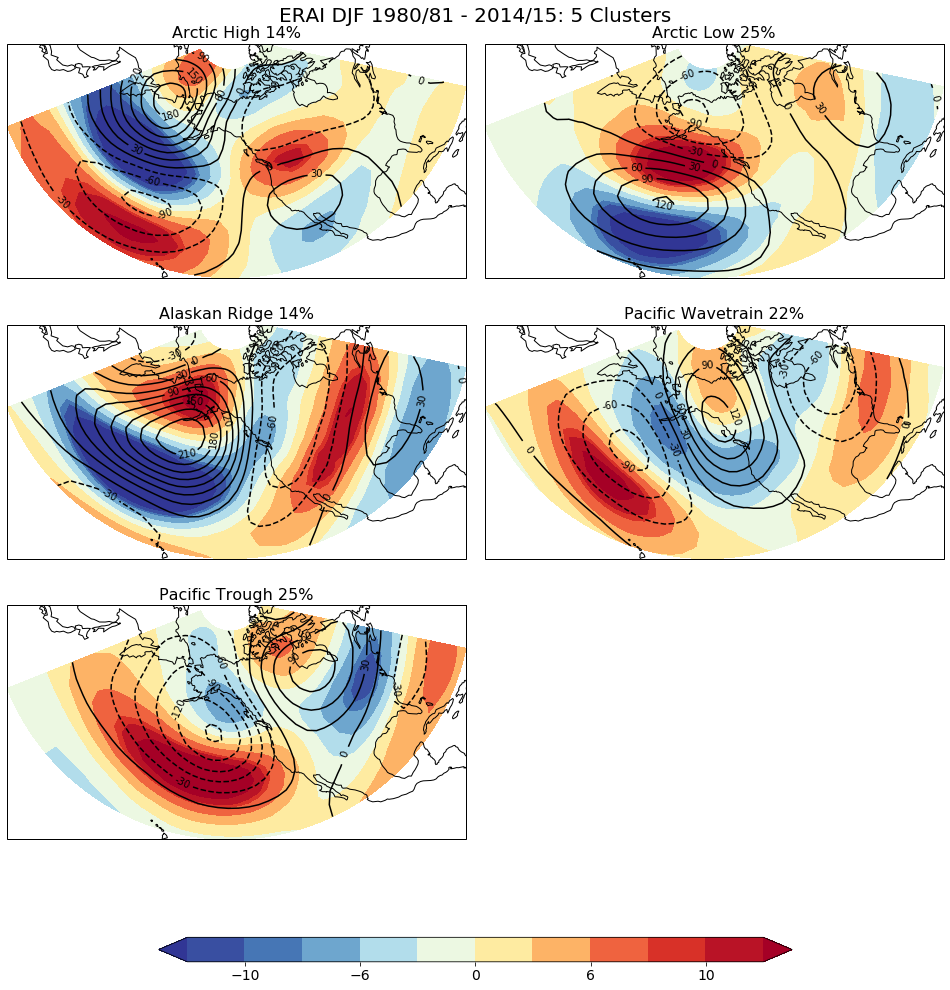

In [13]:
titles=['Arctic High','Arctic Low','Alaskan Ridge','Pacific Wavetrain','Pacific Trough']
freq=np.round((cluster_freq['z500'][:,0,0].values)*100)
cm = 220
minlon = -70 + cm
maxlon = 80 + cm
#clevs=np.arange(-12,13,3)
levs=np.arange(-210,220,30)
clevs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
#    ax.set_extent(extent)
    if (i < 5):
        cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                       cluster_comp['u250'][i,:,:],clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r',extend='both')
        cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                   cluster_comp['z500'][i,:,:]/9.81,levs,colors='k',
                   transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i]+' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
        #ax.gridlines()
        ax.coastlines()
fig.delaxes(axs.flatten()[5])    

plt.suptitle('ERAI DJF 1980/81 - 2014/15: 5 Clusters',fontsize=20)
# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.savefig('ERAI_clusters_5_1980-2015_DJF.png')

### KMeans 4

In [14]:
kmeans4 = KMeans(n_clusters=4,random_state=1,init='random',n_init=100)
kmeans4.fit(ds['pcs'])
y_kmeans4=kmeans4.predict(ds['pcs'])

In [15]:
ds_anoms['cluster']=y_kmeans4
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3080, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 1 1 1 1 1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [16]:
cluster_comp=ds_anoms.groupby('cluster').mean()
cluster_comp

<xarray.Dataset>
Dimensions:  (cluster: 4, lat: 22, lon: 53)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * cluster  (cluster) int64 0 1 2 3
Data variables:
    z500     (cluster, lat, lon) float64 -251.4 -259.5 -267.7 ... 66.5 76.84
    u250     (cluster, lat, lon) float64 -1.211 -1.374 -1.535 ... -1.459 -1.924

In [17]:
cluster_freq=(ds_anoms.groupby('cluster').count())/len(ds['time'])
print(cluster_freq['z500'][:,0,0])

<xarray.DataArray 'z500' (cluster: 4)>
array([0.26753247, 0.1737013 , 0.26525974, 0.29350649])
Coordinates:
  * cluster  (cluster) int64 0 1 2 3
    lat      float64 79.53
    lon      float64 151.9


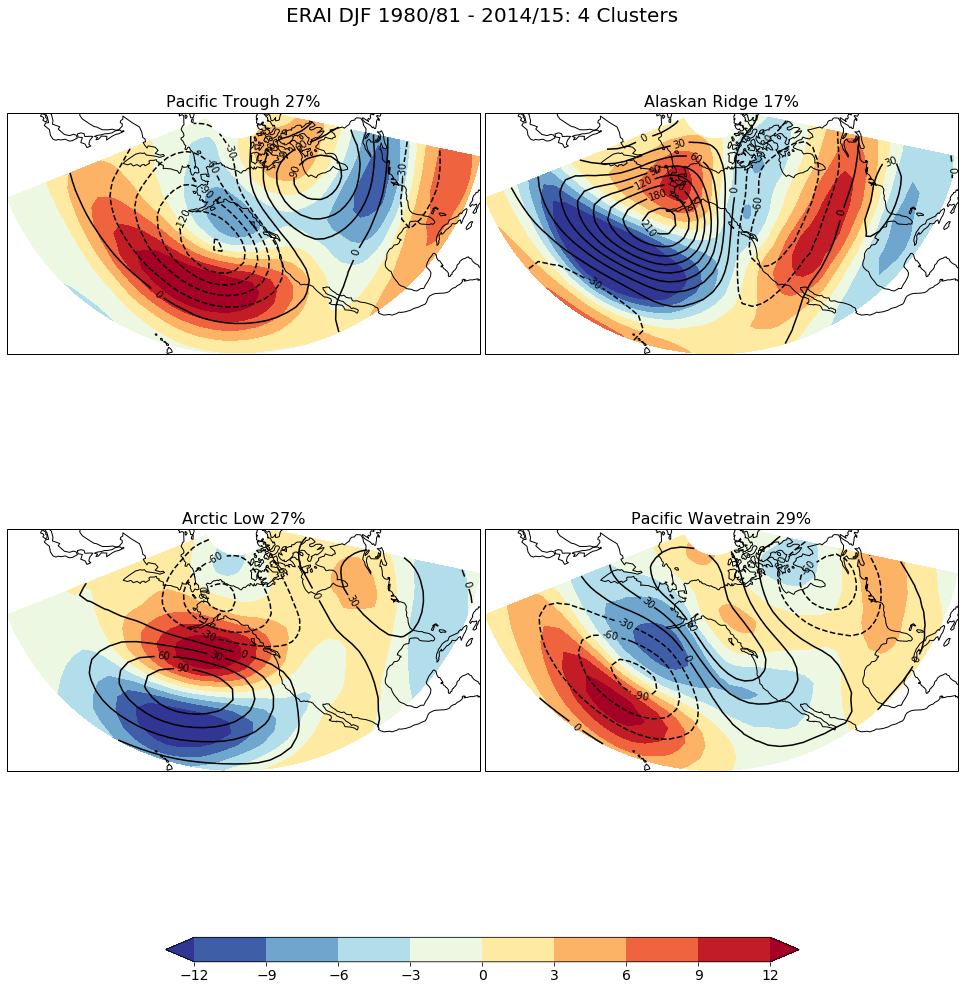

In [18]:
titles=['Pacific Trough','Alaskan Ridge','Arctic Low','Pacific Wavetrain']
freq=np.round((cluster_freq['z500'][:,0,0].values)*100)
cm = 220
minlon = -70 + cm
maxlon = 80 + cm
clevs=np.arange(-12,13,3)
celvs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
levs=np.arange(-210,220,30)
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
fig,axs=plt.subplots(2,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
        cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                       cluster_comp['u250'][i,:,:],clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r',extend='both')
        cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                   cluster_comp['z500'][i,:,:]/9.81,levs,colors='k',
                   transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i]+' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
        ax.coastlines() 

plt.suptitle('ERAI DJF 1980/81 - 2014/15: 4 Clusters',fontsize=20)

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.savefig('ERAI_clusters_4_1980-2015_DJF.png')

### KMeans 6

In [19]:
kmeans6 = KMeans(n_clusters=6,random_state=1,init='random',n_init=100)
kmeans6.fit(ds['pcs'])
y_kmeans6=kmeans6.predict(ds['pcs'])

y_kmeans6.shape

(3080,)

In [21]:
ds_anoms['cluster']=y_kmeans6
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3080, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 3 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 1 1 4 4 4
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [22]:
cluster_comp=ds_anoms.groupby('cluster').mean()
cluster_comp

<xarray.Dataset>
Dimensions:  (cluster: 6, lat: 22, lon: 53)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * cluster  (cluster) int64 0 1 2 3 4 5
Data variables:
    z500     (cluster, lat, lon) float64 -41.03 -47.65 -54.0 ... -51.68 -44.76
    u250     (cluster, lat, lon) float64 0.3545 0.2709 0.188 ... 3.57 3.469

In [23]:
cluster_freq=(ds_anoms.groupby('cluster').count())/len(ds['time'])
print(cluster_freq['z500'][:,0,0])

<xarray.DataArray 'z500' (cluster: 6)>
array([0.16850649, 0.19707792, 0.18311688, 0.13181818, 0.12727273,
       0.19220779])
Coordinates:
  * cluster  (cluster) int64 0 1 2 3 4 5
    lat      float64 79.53
    lon      float64 151.9


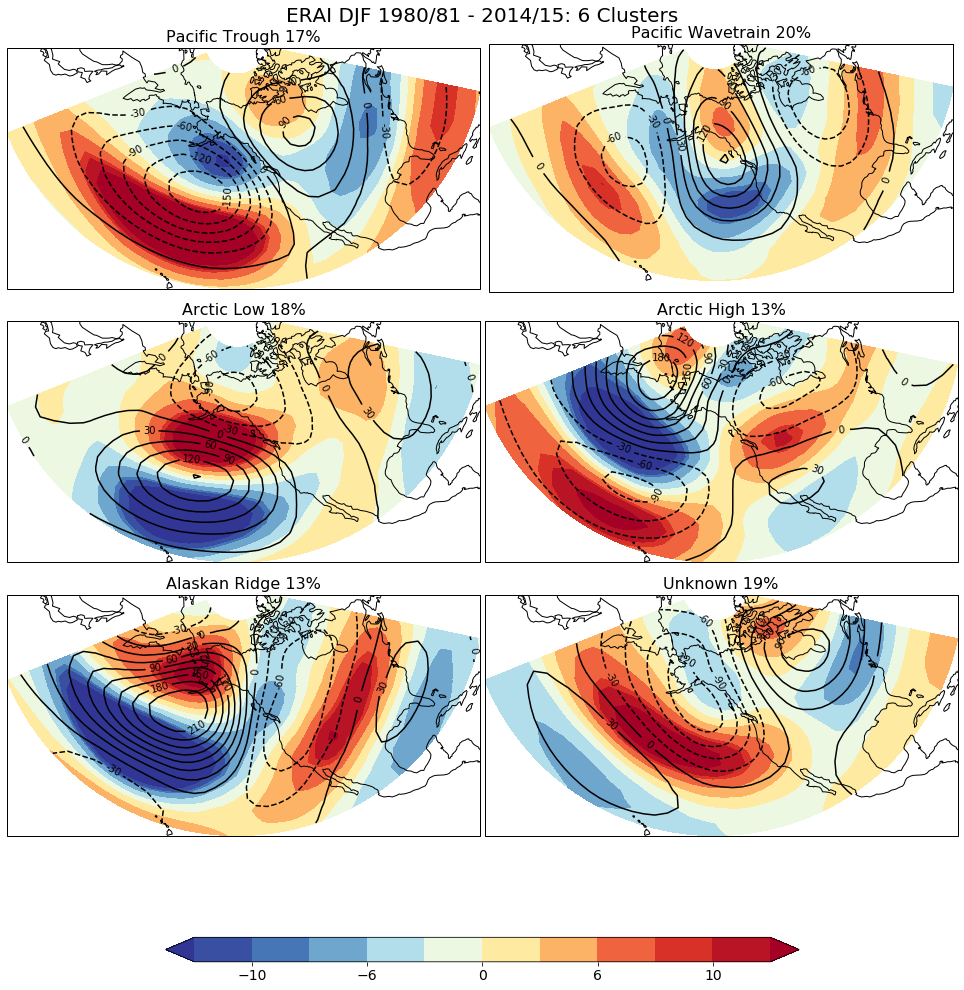

In [24]:
titles=['Pacific Trough','Pacific Wavetrain','Arctic Low','Arctic High','Alaskan Ridge','Unknown']
freq=np.round((cluster_freq['z500'][:,0,0].values)*100)
cm = 220
minlon = -70 + cm
maxlon = 80 + cm
clevs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
levs=np.arange(-210,220,30)
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
        cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                       cluster_comp['u250'][i,:,:],clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r',extend='both')
        cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                   cluster_comp['z500'][i,:,:]/9.81,levs,colors='k',
                   transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i]+' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
        ax.coastlines() 

plt.suptitle('ERAI DJF 1980/81 - 2014/15: 6 Clusters',fontsize=20)

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.savefig('ERAI_clusters_6_1980-2015_DJF.png')